In [3]:
#import the required libraries and packages

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import skimage
import matplotlib.pyplot as plt
from skimage.feature import canny
import cv2
import shutil
import random
import numpy as np

import json

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [4]:
#load the dataset

# DeapSearov
#     |-->train
#     |-->test
#     |-->validation
#     |-->train_augmented


dataset_path = "DeapSearov"

train_dir = "train"#os.path.join(dataset_path, "train")
test_dir = "test" #os.path.join(dataset_path, "test")
validation_dir = "validation" #os.path.join(dataset_path, "validation")

train_augmented_dir = "train_augmented"#os.path.join(dataset_path, "train_augmented")

Data Processing

In [ ]:

#source = train_dir, so use for loop on sub folders
def median_noise(source, blur = 3):
        img = source
        median = cv2.medianBlur(img, blur)
        return (median)

def gaussian_noise(source,kernal = (5,5), blur = 5):
        img = source
        gaussian = cv2.GaussianBlur(img, kernal, blur)
        return (gaussian)


def adaptive_histogram_equalization(source):
        img = source
        # Convert to LAB color space
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab_image)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Merge channels and convert back to BGR
        lab_clahe = cv2.merge((l_clahe, a, b))
        result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

        return (result)


def resize(source, size = (224,224)):
        img = source
        result = cv2.resize(img, size)
        return (result)

def grayscale(source):
        return cv2.imread(source, cv2.IMREAD_GRAYSCALE)

def histogram_equalize(source):
        img = source
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        eq_img = cv2.equalizeHist(gray)

        return (eq_img)

def standard_img(source):
        img = source
        if img.dtype == bool:
                img = img.astype(np.uint8) * 255
        mean, std = cv2.meanStdDev(img)

        mean, std = cv2.meanStdDev(img)
        if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale
                mean = mean.reshape((1, 1, 1))
                std = std.reshape((1, 1, 1))
        else:  # Color (3 channels)
                mean = mean.reshape((1, 1, 3))
                std = std.reshape((1, 1, 3))
        std_img = (img - mean) / std

        return (std_img)

def thresholding(source):
        img = source
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary  = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        return (binary)

def preprocess_image(source):
    img_path = source

    if isinstance(img_path, str):
        img = cv2.imread(img_path)
    else:
        img = img_path

    if img is None:
        raise ValueError("Could not load image")


    resized = resize(img)
    denoised = gaussian_noise(resized, blur=5)
    equalized = adaptive_histogram_equalization(denoised)
    threshold = thresholding(equalized)
    normalized = standard_img(threshold)

    img = normalized

    if len(img.shape) == 3 and img.shape[0] == 1:
        img = img.squeeze()

    return img



Data AUGMENTATION

In [3]:
def r_90_c(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_CLOCKWISE)

def r_90_ac(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_COUNTERCLOCKWISE)

def r_180(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_180)

def flip_h(source):
    return cv2.flip(cv2.imread(source, cv2.IMREAD_UNCHANGED), 0)

def flip_v(source):
    return cv2.flip(cv2.imread(source, cv2.IMREAD_UNCHANGED), 1)

def shifting(source, offset = (-50, 50)):
    x_shift = random.randint(offset[0], offset[1])
    y_shift = random.randint(offset[0], offset[1])

    img = cv2.imread(source, cv2.IMREAD_UNCHANGED)
    rows, cols = img.shape[:2]

    translation_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])

    # Perform the translation
    shifted_image = cv2.warpAffine(img, translation_matrix, (cols, rows))

    # Calculate the cropping region
    x_start = max(0, x_shift)
    y_start = max(0, y_shift)
    x_end = cols - max(0, -x_shift)
    y_end = rows - max(0, -y_shift)

    # Crop the shifted image to remove the black border
    cropped_image = shifted_image[y_start:y_end, x_start:x_end]

    return cv2.resize(cropped_image, (224,224))

def blur(source, blur_type="gaussian", kernel_size=(5, 5)):
    image = cv2.imread(source, cv2.IMREAD_UNCHANGED)

    if blur_type == "average":
        return cv2.blur(image, kernel_size)
    elif blur_type == "gaussian":
        return cv2.GaussianBlur(image, kernel_size, 0)


In [99]:

augmentation = [r_90_c, r_90_ac, r_180, flip_h, flip_v, shifting, blur]

# Creating the augmented training dataset

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        dest_subfolder = os.path.join(train_augmented_dir, subfolder)

        # Create the destination subfolder if it doesn't exist
        os.makedirs(dest_subfolder, exist_ok=True)

        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            # Check if it's a file (not a subdirectory)
            if os.path.isfile(image_path):
                for aug_func in augmentation:
                    augmented_image = aug_func(image_path)
                    # Generate a unique filename for the augmented image
                    name, ext = os.path.splitext(image_file)
                    new_filename = f"{name}_{aug_func.__name__}{ext}"
                    new_image_path = os.path.join(dest_subfolder, new_filename)

                    cv2.imwrite(new_image_path, augmented_image)

In [5]:



#All three sets are preprocessed here
train_data = ImageDataGenerator(rescale= 1.0/255)
test_data = ImageDataGenerator(rescale= 1.0/255)
validation_data = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_data.flow_from_directory(
    train_augmented_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

test_generator = test_data.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

validation_generator = validation_data.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

Found 21336 images belonging to 33 classes.
Found 660 images belonging to 33 classes.
Found 667 images belonging to 33 classes.


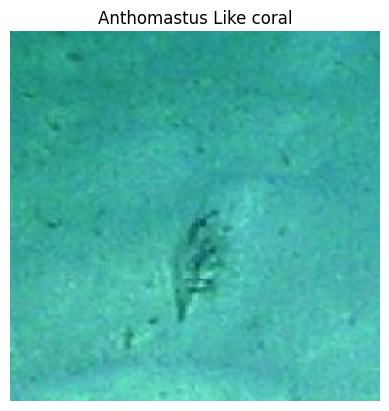

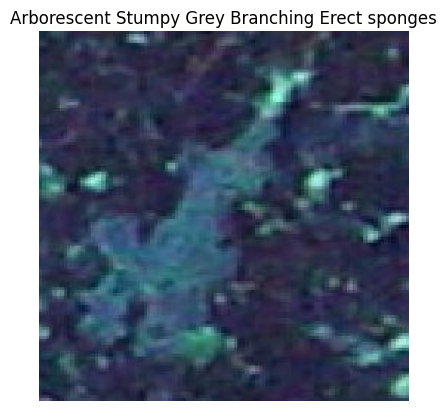

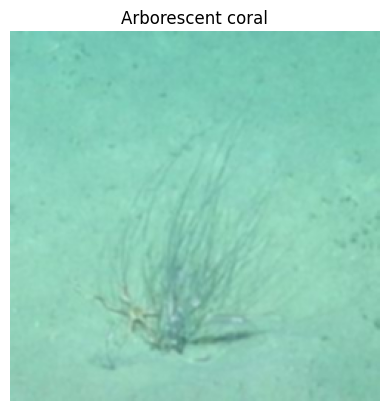

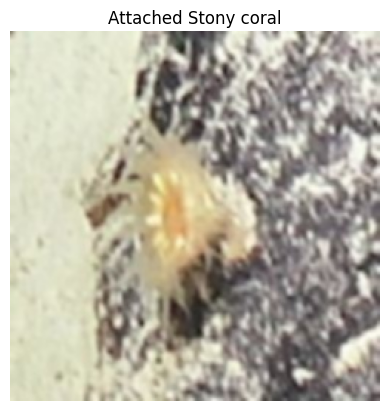

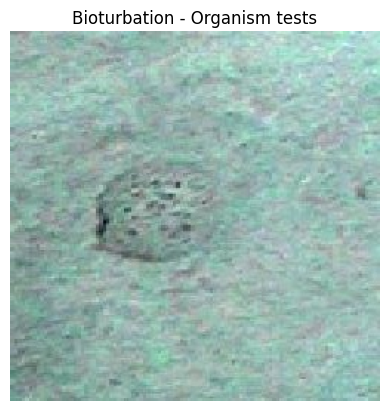

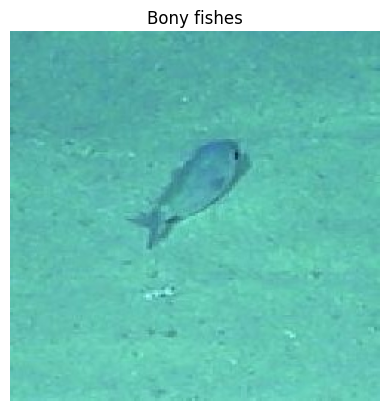

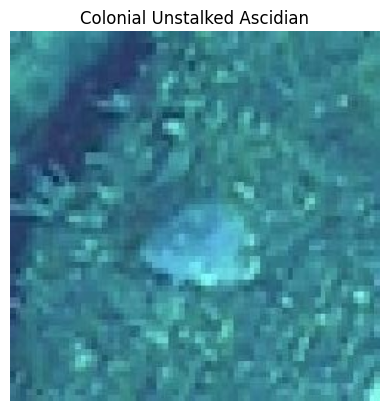

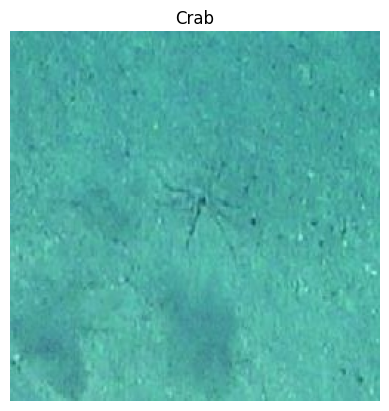

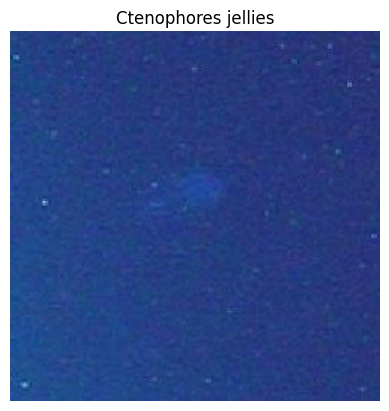

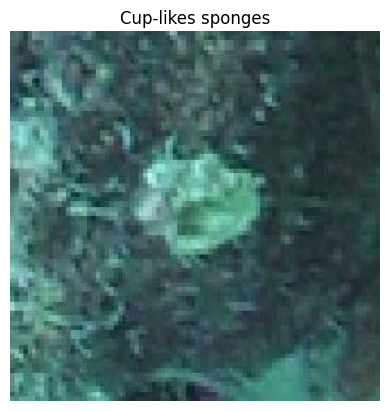

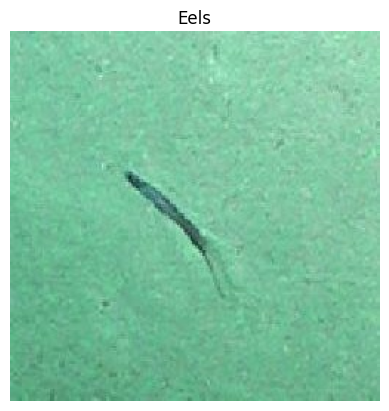

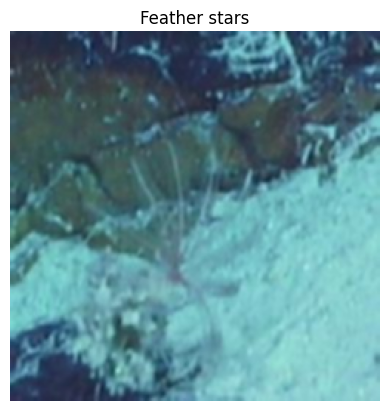

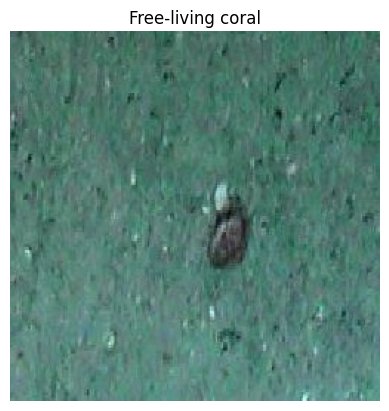

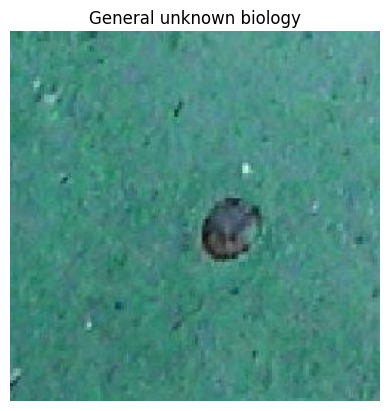

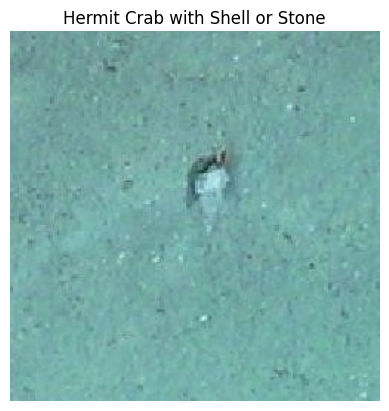

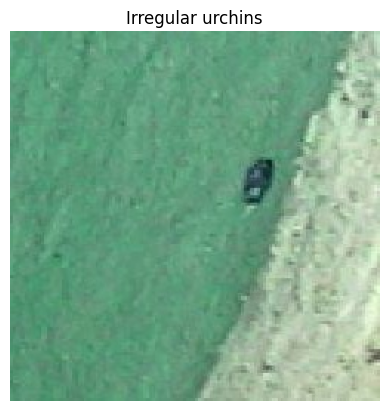

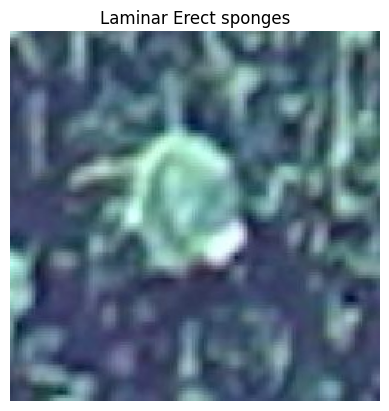

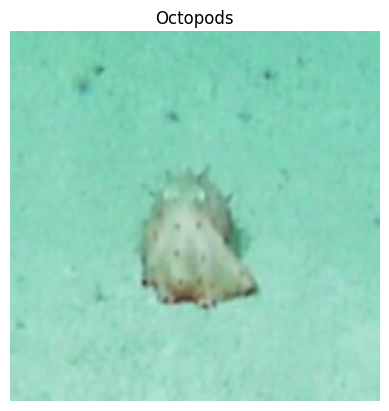

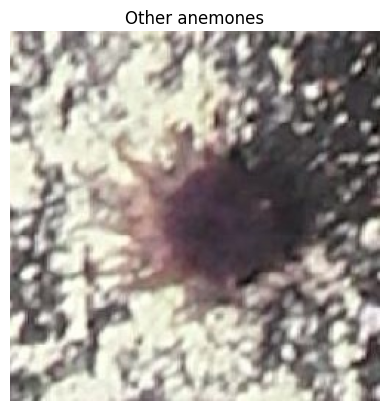

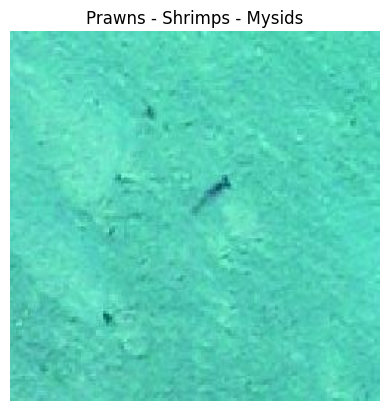

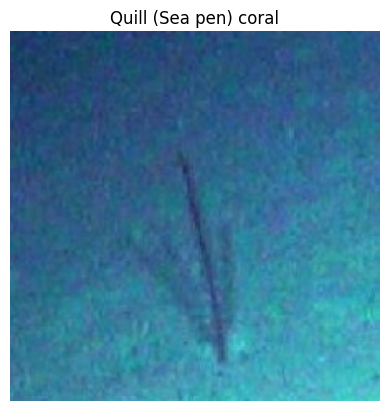

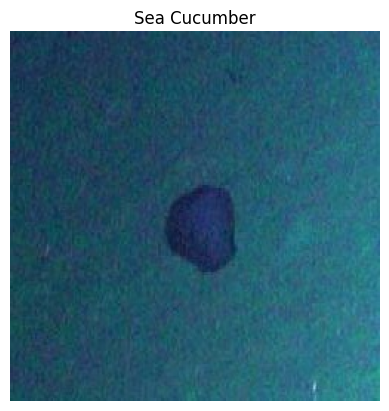

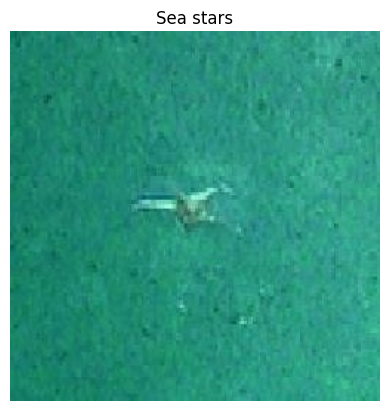

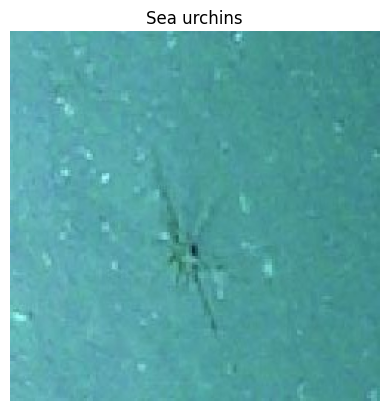

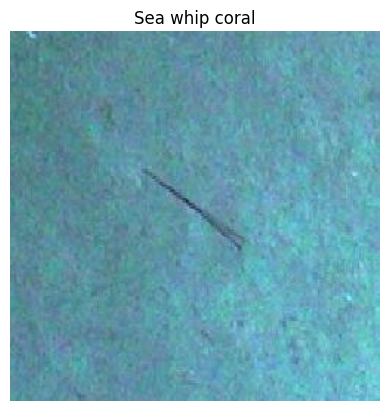

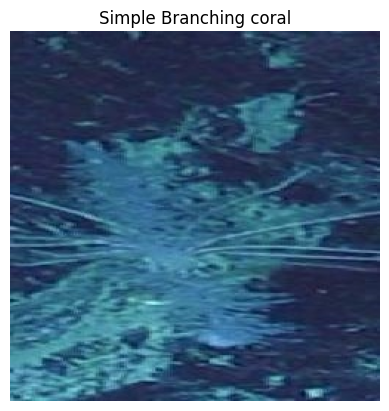

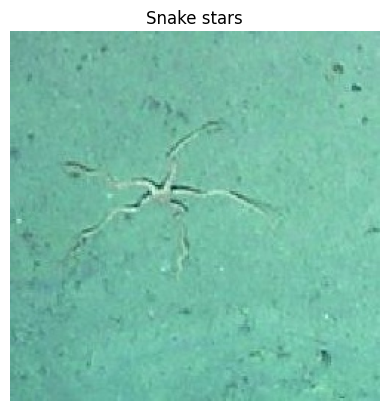

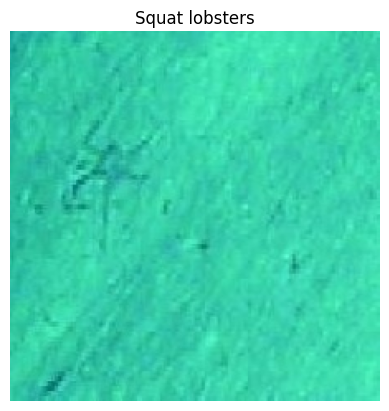

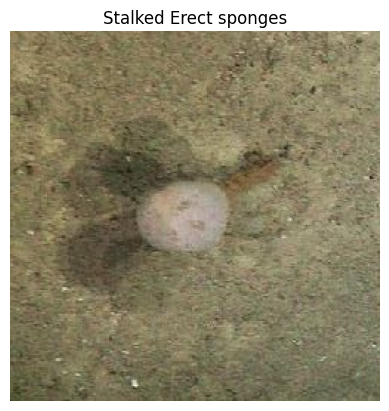

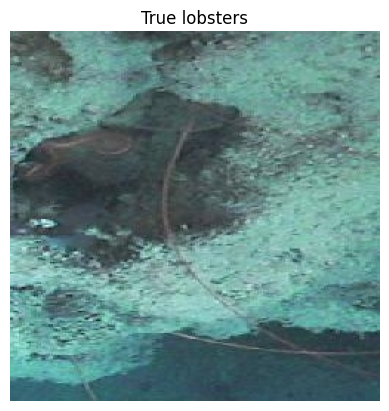

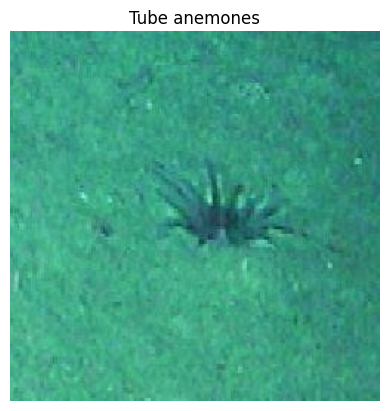

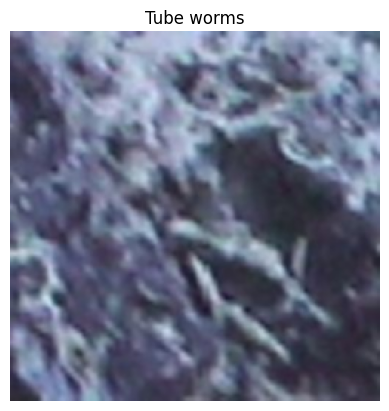

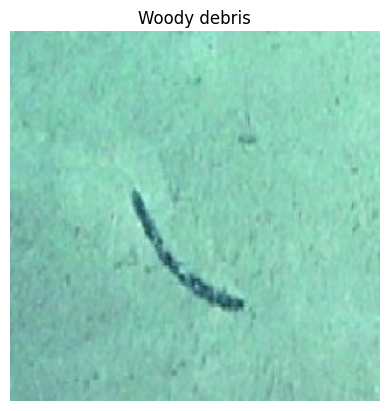

In [ ]:
class_indices = train_generator.class_indices
images_per_class = {}

for class_name in list(class_indices.keys()):
    class_dir = os.path.join(train_dir, class_name)
    images = list(os.listdir(class_dir))

    images_per_class[class_name] = os.path.join(class_dir, images[0])

class_names = list(images_per_class.keys())

for class_name, image in images_per_class.items():
    img = load_img(image)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
    plt.show()

In [6]:
model = Sequential()

In [7]:
model.add(Conv2D(filters= 32,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 32,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

model.add(Conv2D(filters= 64,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 64,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

model.add(Conv2D(filters= 128,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 128,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

model.add(Conv2D(filters= 256,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 256,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

model.add(Conv2D(filters= 512,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 512,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

model.add(Conv2D(filters= 1024,kernel_size= 3, padding= "same", activation= "relu", input_shape = (224,224,3)))
model.add(Conv2D(filters= 1024,kernel_size= 3, activation= "relu"))
model.add(MaxPooling2D(pool_size= 2, strides= 2))

c:\Users\Azeem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units= 1900, activation= "relu"))
model.add(Dropout(0.4))
model.add(Dense(units= 33, activation= "softmax"))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), loss= "categorical_crossentropy", metrics= ["accuracy"])
#tf.keras.optimizers.Adam(learning_rate=0.001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1900)           │     1,947,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 33)             │        62,733 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,880,281 (79.65 MB)

 Trainable params: 20,880,281 (79.65 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
training_accuracy = model.fit(train_generator, epochs= 10, validation_data= validation_generator)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


667/667 ━━━━━━━━━━━━━━━━━━━━ 139s 198ms/step - accuracy: 0.1513 - loss: 2.9674 - val_accuracy: 0.2307 - val_loss: 2.5377
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 131s 186ms/step - accuracy: 0.2664 - loss: 2.4767 - val_accuracy: 0.3378 - val_loss: 2.2714
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 140s 183ms/step - accuracy: 0.3654 - loss: 2.1464 - val_accuracy: 0.3982 - val_loss: 1.9970
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 122s 183ms/step - accuracy: 0.4697 - loss: 1.8094 - val_accuracy: 0.4714 - val_loss: 1.8571
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - accuracy: 0.5410 - loss: 1.5230 - val_accuracy: 0.5387 - val_loss: 1.6364
Epoch 6/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 122s 182ms/step - accuracy: 0.5993 - loss: 1.3125 - val_accuracy: 0.5517 - val_loss: 1.6482
Epoch 7/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 125s 187ms/step - accuracy: 0.6569 - loss: 1.0945 - val_accuracy: 0.5665 - val_loss: 1.5547
Epoch 8/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 140s 183ms/step - accuracy: 0.7042 - loss: 0.92

In [105]:
model.save("Deepsea_4.keras")


with open("deapsea4.json", "w") as f:
  json.dump(training_accuracy.history, f)

In [134]:
model = tf.keras.models.load_model("DeapSearov_F/Deepsea_4.keras")

#Evaluation of train, test, validation sets
train_loss, train_accuracy = model.evaluate(train_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


667/667 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.9217 - loss: 0.3030


In [125]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6517 - loss: 1.4115


In [126]:
test_loss, test_accuracy = model.evaluate(test_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.6530 - loss: 1.4841


In [135]:
print(f"Training Accuracy: {train_accuracy * 100:.2f}% , Training Loss: {train_loss}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}% , Validation Loss: {validation_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}% , Test Loss: {test_loss}")

Training Accuracy: 92.08% , Training Loss: 0.3008247911930084
Validation Accuracy: 64.02% , Validation Loss: 1.4591540098190308
Test Accuracy: 63.79% , Test Loss: 1.5901485681533813


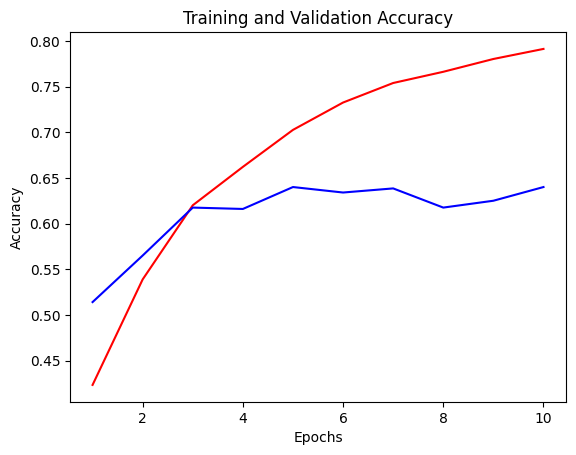

In [136]:
with open("DeapSearov_F/deapsea4.json", "r") as f:
    training_history = json.load(f)

epochs = [i for i in range(1,11)]

plt.plot(epochs, training_history["accuracy"], label="Training Accuracy", color = 'red')
plt.plot(epochs, training_history["val_accuracy"], label="Validation Accuracy", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.show()

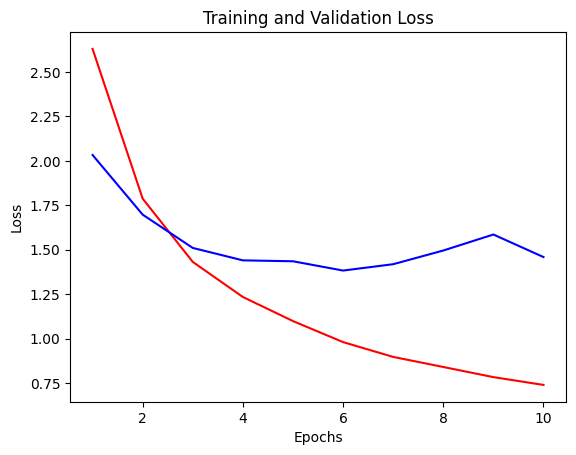

In [137]:
plt.plot(epochs, training_history["loss"], label="Training Loss", color = 'red')
plt.plot(epochs, training_history["val_loss"], label="Validation Loss", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.show()

In [72]:
class_name = list(train_generator.class_indices.keys())


In [114]:
test_set = test_data.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32
)

Found 660 images belonging to 33 classes.


In [138]:
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [139]:
true_categories = tf.concat([test_set[i][1] for i in range(len(test_set))], axis=0)


In [140]:
Y_true = tf.argmax(true_categories, axis=1)


In [141]:

cm = confusion_matrix(Y_true, predicted_categories)

#classification_report = (classification_report(Y_true, predicted_categories, target_names = class_name))

In [142]:
def plot_all_classes_roc(y_true, y_pred, n_classes):
    """
    Plot ROC curves for all classes

    """

    plt.figure(figsize=(12, 8))

    # Convert TensorFlow tensors to NumPy arrays before using NumPy functions
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    for i in range(n_classes):
        # Convert to binary classification problem
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for this class
        plt.plot(fpr, tpr, lw=2,
                label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend(loc="lower right", prop={'size': 8})

    return plt

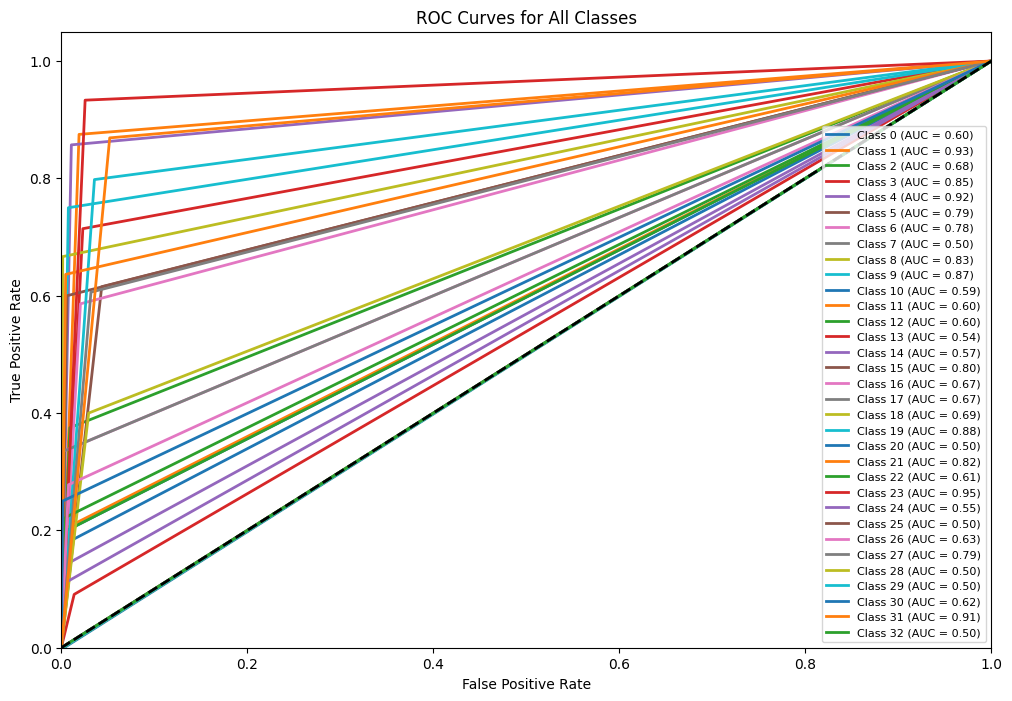

In [143]:
n_classes = 33  # number of classes
plt = plot_all_classes_roc(Y_true, predicted_categories, n_classes)
plt.show()